# Fitting of thermal and chemical denaturation model to fluorescence measurement of DNAJB6b

Copyright © [2024] Technical University of Denmark

Prepared by Celia Fricke (celfri@dtu.dk) and Lars Boyens-Thiele (laksbo@dtu.dk)

Code based on the approach from Hamborg et al., Analytical Biochemistry 2020, 605, 113863. https://doi.org/10.1016/j.ab.2020.113863.

November 2024

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.cm import viridis

from lmfit import Model, Parameters, fit_report

from dataclasses import dataclass

In [2]:
plt.rcParams.update({'font.family':'Arial'})
plt.rcParams.update({'pdf.fonttype': 42})

In [3]:
## Dataclass for each measurement

@dataclass
class pantasample:
    T: np.ndarray
    f330: np.ndarray
    f350: np.ndarray
    denaturant: float

In [4]:
## load data

df=pd.read_csv('nanoDSF_B6.txt', sep = '\t')

# Denaturant concentrations in M
denaturants = [0, 0.08, 0.4, 0.8, 1.2, 1.6, 2, 2.4, 2.8, 3.2, 3.6, 4, 4.4, 4.8, 5.2, 5.6, 6, 6.4]


B6 = [] # List for storing unfolding measurements
for i in range(18):
    B6.append(pantasample(df[df.columns[i*12]].values+273.15, df[df.columns[i*12+9]].values, df[df.columns[i*12+5]].values, denaturants[i])) 
    
B6_refolding = [] # List for storing refolding measurements
for i in range(18):
    B6_refolding.append(pantasample(df[df.columns[i*12+10]].values+273.15, df[df.columns[i*12+11]].values, df[df.columns[i*12+7]].values, denaturants[i]))

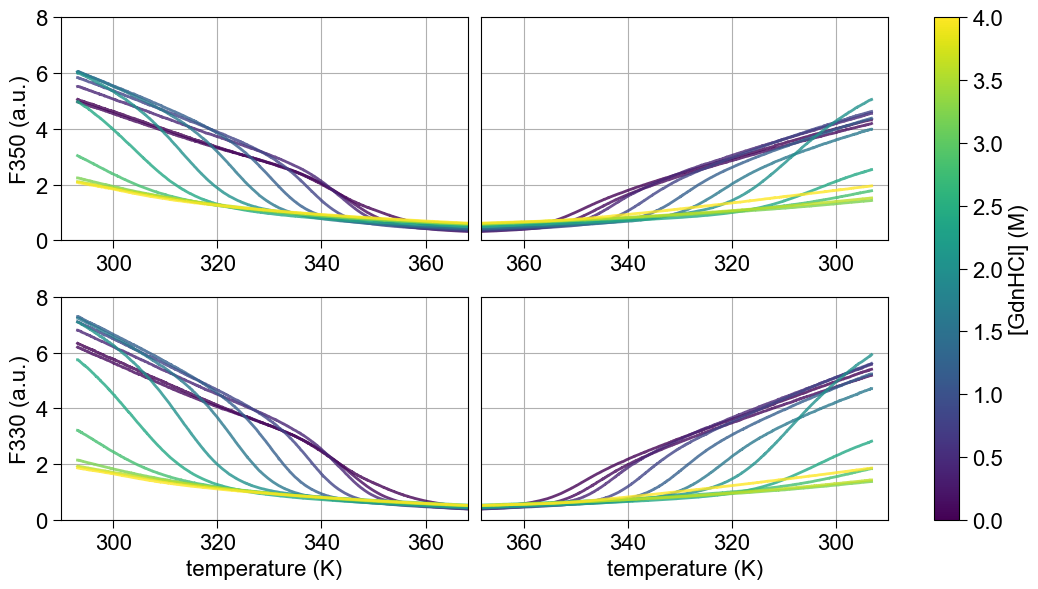

In [5]:
## Plot overview of data

# Define colormap
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

figs, axs =plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharey=True)

# Plot unfolding measurements
for cap in B6[0:12]:
    axs[0,0].plot(cap.T, cap.f350/1000, color=cmap(norm(cap.denaturant)), alpha = 0.8, linewidth=2)
    axs[1,0].plot(cap.T, cap.f330/1000, color=cmap(norm(cap.denaturant)), alpha = 0.8, linewidth=2)
    axs[1,0].set_xlabel('temperature (K)', fontsize = 16)
    axs[0,0].set_ylabel('F350 (a.u.)', fontsize = 16)
    axs[1,0].set_ylabel('F330 (a.u.)', fontsize = 16)
    axs[0,0].tick_params(axis='both', labelsize=16, length=6)
    axs[1,0].tick_params(axis='both', labelsize=16, length=6)
    axs[1,0].set_ylim(0, 8)
    axs[0,0].set_ylim(0,8)
    axs[0,0].set_xlim(290, max(cap.T))
    axs[1,0].set_xlim(290, max(cap.T))

# Plot refolding measurements
for cap in B6_refolding[0:12]:
    axs[0,1].plot(cap.T, cap.f350/1000, color=cmap(norm(cap.denaturant)), alpha = 0.8, linewidth=2)
    axs[1,1].plot(cap.T, cap.f330/1000, color=cmap(norm(cap.denaturant)), alpha = 0.8, linewidth=2)
    axs[1,1].set_xlabel('temperature (K)', fontsize = 16)
    axs[0,1].tick_params(axis='y', labelsize=16, length=0)
    axs[1,1].tick_params(axis='y', labelsize=16, length=0)
    axs[0,1].tick_params(axis='x', labelsize=16, length=6)
    axs[1,1].tick_params(axis='x', labelsize=16, length=6)
    axs[1,1].set_xlim(290, max(cap.T))
    axs[0,1].set_xlim(290, max(cap.T))


axs[0,1].invert_xaxis()
axs[1,1].invert_xaxis()
plt.subplots_adjust(wspace=0)
plt.tight_layout()
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.05)
cbar.set_label('[GdnHCl] (M)', fontsize=16)
cbar.ax.tick_params(labelsize=16, length=6)
axs[0,1].grid(True)
axs[1,1].grid(True)
axs[0,0].grid(True)
axs[1,0].grid(True)

In [6]:
## Function of fluorescent signal of thermally and chemically denatured protein

def fluorescence(T=320, x=0, Tref=320,
    a0=-1, a1=-1, b0=1, b1=1, c0=1, c1=1,
    fN_Tref=1, fD_Tref=1,
    Tm=1, dH=1, dCp=1, m=1):
    """
    Parameters:
        T: Temperature in K
        x: Concentration of denaturant in M
        Tref: reference temperature in K
        a0: First order temperature dependence of the fluorescence of the native state
        a1: First order temperature dependence of the fluorescence of the denatured state
        b0: Second order temperature dependence of the fluorescence of the native state
        b1: Second order temperature dependence of the fluorescence of the denatured state
        c0: Denaturant concentration dependence of the fluorescence of the native state
        c1: Denaturant concentration dependence of the fluorescence of the denatured state
        fN_Tref: Fluorescent signal in absence of denaturant at the reference temperature of the native state
        fD_Tref: Fluorescent signal in absence of denaturant at the reference temperature of the denatured state
        Tm: Melting temperature in K in absence of dcenaturant
        dH: Change in enthalpy of unfolding in J/mol
        dCp: Change in heat capacity of unfolding in J/(K*mol)
        m: m-value in J/(mol*M)
    """
    
    R = 8.314
    dT = T-Tref
    
    # Fluorescence signal of the native (fN) and denatured (fD) states
    fN = fN_Tref + a0*dT + b0*dT**2 + c0*x
    fD = fD_Tref + a1*dT + b1*dT**2 + c1*x
    
    # Calculate change in free energy
    dG_D = dH*(1-T/Tm) + dCp*(T-Tm-T*np.log(T/Tm)) - x*m
    
    return (fN + fD*np.exp(-dG_D/(R*T)) ) / (1 + np.exp(-dG_D/(R*T)))

In [7]:
## Function for combining fluorescence at two wavelengths

def combine_fluorescence(T, x, Tref, wavelength,
            a0_1, a1_1, b0_1, b1_1, c0_1, c1_1, fN_Tref_1, fD_Tref_1,
            a0_2, a1_2, b0_2, b1_2, c0_2, c1_2, fN_Tref_2, fD_Tref_2,
            Tm, dH, dCp, m):
    
    idx350 = wavelength==350 
    idx330 = wavelength==330 
    
    arr350 = fluorescence(T=T[idx350], x=x[idx350], Tref=Tref,
        a0=a0_1, a1=a1_1, b0=b0_1, b1=b1_1, c0=c0_1, c1=c1_1,
        fN_Tref=fN_Tref_1, fD_Tref=fD_Tref_1,
        Tm=Tm, dH=dH, dCp=dCp, m=m)
        
    arr330 = fluorescence(T=T[idx330], x=x[idx330], Tref=Tref,
        a0=a0_2, a1=a1_2, b0=b0_2, b1=b1_2, c0=c0_2, c1=c1_2,
        fN_Tref=fN_Tref_2, fD_Tref=fD_Tref_2,
        Tm=Tm, dH=dH, dCp=dCp, m=m)
    
    return np.hstack([arr350, arr330])


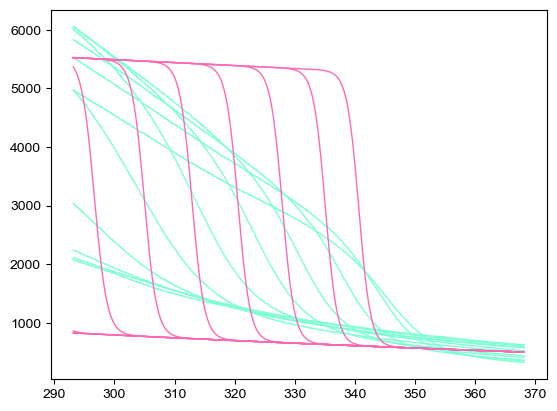

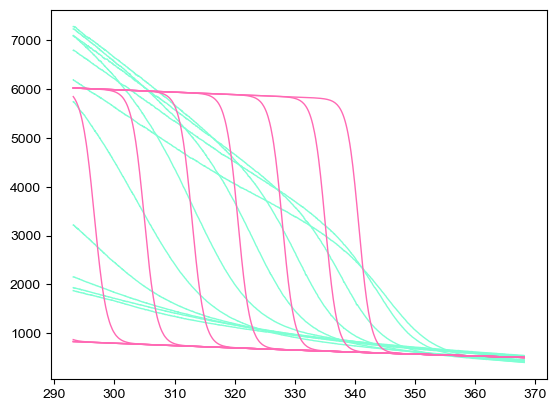

In [8]:
## Define model and initial guess

# Reference temperature
reference_temp = 25+273.15

cs = B6[1:12]
l = len(cs[0].T)

# Prepare arrays of temperature, signals, denaturant concentrations, and wavelengths
Ts = np.vstack([cap.T for cap in cs]*2).flatten()
Fs = np.vstack([cap.f350 for cap in cs]+[cap.f330 for cap in cs]).flatten()
xs = np.array([[cap.denaturant]*len(cap.T) for cap in cs]*2).flatten()
wavelengths = np.repeat([330, 350], len(Ts)//2)

# Define parameters an initial guesses
params = Parameters()
params.add_many(
    ('a0_1',		 -5,		True, None, None, None, None),
    ('a1_1',		 -5,		True, None, None, None, None),
    ('b0_1',		 -0,		False, None, None, None, None),
    ('b1_1',		 0.01,		True, None, None, None, None),
    ('c0_1',		 -0.0,		True, None, None, None, None),
    ('c1_1',		 0.01,		True, None, None, None, None),
    ('fN_Tref_1',	 5500,		True, 0, None, None, None),
    ('fD_Tref_1',	 800,		True, 0, None, None, None),
    
    ('a0_2',		 -5,		True, None, None, None, None),
    ('a1_2',		 -5,		True, None, None, None, None),
    ('b0_2',		 0.0,		False, None, None, None, None),
    ('b1_2',		 0.01,		True, None, None, None, None),
    ('c0_2',		 0,			True, None, None, None, None),
    ('c1_2',		 0.01,		True, None, None, None, None),
    ('fN_Tref_2',	 6000,		True, 0, None, None, None),
    ('fD_Tref_2',	 800,		True, 0, None, None, None),
    
    ('Tm',			 342,		True, 0, None, None, None),
    ('dH',			 10e5,		True, None, None, None, None),
    ('dCp',			 4e3,		True, 0, None, None, None),
    ('m',			 5e4,		True, 0, None, None, None),
)

# Define model
model = Model(combine_fluorescence, independent_vars=("T", "x", "Tref", "wavelength"))

# Plot data and initial guess
for i in range(2):
    plt.plot(Ts.reshape(-1, l).T[:,i*len(cs):(i+1)*len(cs)], Fs.reshape(-1, l).T[:,i*len(cs):(i+1)*len(cs)], 
                    color="aquamarine", linewidth=1, alpha=1);
    
    plt.plot(Ts.reshape(-1, l).T[:,i*len(cs):(i+1)*len(cs)], 
             model.eval(params=params, T=Ts, x=xs, Tref=reference_temp, wavelength=wavelengths).reshape(-1, l).T[:,i*len(cs):(i+1)*len(cs)],
            color="hotpink", linewidth=1, alpha=1);

    plt.show()

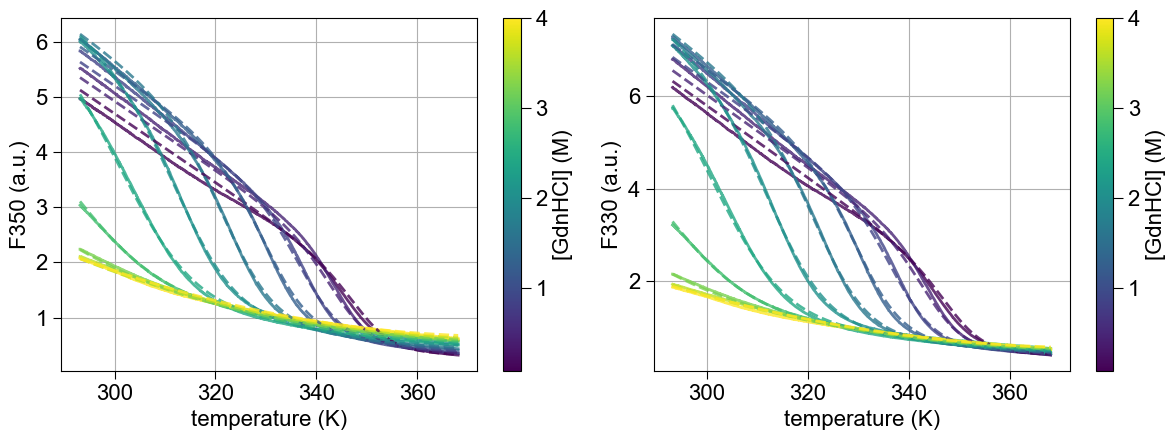

[[Model]]
    Model(combine_fluorescence)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 193
    # data points      = 20328
    # variables        = 18
    chi-square         = 92545172.5
    reduced chi-square = 4556.63085
    Akaike info crit   = 171267.951
    Bayesian info crit = 171410.506
    R-squared          = 0.99857951
[[Variables]]
    a0_1:      -62.2820100 +/- 0.12436162 (0.20%) (init = -5)
    a1_1:      -31.2504347 +/- 0.16007677 (0.51%) (init = -5)
    b0_1:       0 (fixed)
    b1_1:       0.19729809 +/- 0.00213352 (1.08%) (init = 0.01)
    c0_1:       707.082583 +/- 3.09924444 (0.44%) (init = -0)
    c1_1:       87.7341646 +/- 0.93513612 (1.07%) (init = 0.01)
    fN_Tref_1:  4754.53297 +/- 3.45516483 (0.07%) (init = 5500)
    fD_Tref_1:  1548.95109 +/- 4.42136242 (0.29%) (init = 800)
    a0_2:      -77.7949028 +/- 0.13247595 (0.17%) (init = -5)
    a1_2:      -29.3605051 +/- 0.16388082 (0.56%) (init = -5)
    b0_2:       0 (fixed)
    b1_

In [9]:
## Fit model and plot and print results

# Fit model to data
result = model.fit(Fs, params, T=Ts, x=xs, Tref=reference_temp, wavelength=wavelengths, 
                   method="leastsq", calc_covar=True)


figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4.5))
denat = denaturants[1:12]
num_lines = 11
normalize = Normalize(vmin=0, vmax=num_lines - 1)
line_colors_observed = viridis(normalize(range(num_lines)))
line_labels_observed = [f'{denat[i]} M' for i in range(num_lines)]
    
# Plot observed data with different colour
for i in range(2):    
    for j in range(len(cs)):
        axs[i].plot(Ts.reshape(-1, l).T[:, i * len(cs) + j], 
                    (Fs.reshape(-1, l).T[:, i * len(cs) + j])/1000, 
                    color=line_colors_observed[j], linewidth=2, alpha=0.8, label=line_labels_observed[j])
    
    # Plot best fit data using the same colors as observed data
    for j in range(len(cs)):
        axs[i].plot(Ts.reshape(-1, l).T[:, i * len(cs) + j], 
                    (result.best_fit.reshape(-1, l).T[:, i * len(cs) + j])/1000, 
                    '--', color=line_colors_observed[j], linewidth=2, alpha=0.8)   
    
axs[0].set_ylabel("F350 (a.u.)", fontsize = 16)
axs[1].set_ylabel("F330 (a.u.)", fontsize = 16)
axs[0].set_xlabel("temperature (K)", fontsize = 16)
axs[1].set_xlabel("temperature (K)", fontsize = 16)
axs[0].tick_params(axis='both', labelsize=16, length=6)
axs[1].tick_params(axis='both', labelsize=16, length=6)


norm1 = matplotlib.colors.Normalize(vmin=np.min(denat), vmax=np.max(denat))
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm1)
cbar1 = plt.colorbar(sm1, ax=axs[1])
cbar1.set_label('[GdnHCl] (M)', fontsize=16)
cbar1.ax.tick_params(labelsize=16, length=7)
cbar2 = plt.colorbar(sm1, ax=axs[0])
cbar2.set_label('[GdnHCl] (M)', fontsize=16)
cbar2.ax.tick_params(labelsize=16, length=7)
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
plt.show()
print(result.fit_report())